In [1]:
#install dependancies
!pip install datashader
!pip install tqdm

In [2]:
#import required libraries
import os
import time
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from sklearn.cluster import KMeans, DBSCAN
import multiprocessing
from pathlib import Path
from pprint import pprint
from  tqdm import tqdm
import re
tqdm.pandas(desc="Progress BAR!")


In [3]:
#Load the csv files
DATA_PATH = Path("../data")
all_csvs = list(DATA_PATH.glob("*.csv"))
pprint(all_csvs)

[WindowsPath('../data/hashtag_donaldtrump.csv'),
 WindowsPath('../data/hashtag_joebiden.csv')]


In [4]:
## Only pick these columns
USE_COLS = [
    'created_at', 'tweet', 'likes', 'retweet_count',
    'source', 'user_screen_name', 'lat',
    'long', 'country', 'state'
]

## Number of rows to include from each CSV
N_ROWS = 40000

In [5]:
#Read csv into df and combine into one 
trump = pd.read_csv(all_csvs[0],nrows=N_ROWS,usecols=USE_COLS,lineterminator="\n")
biden = pd.read_csv(all_csvs[1],nrows=N_ROWS,usecols=USE_COLS,lineterminator="\n")
df = pd.concat([trump,biden])

In [6]:
df.head()

,created_at,tweet,likes,retweet_count,source,user_screen_name,lat,long,country,state
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,elsollatinonews,25.774270,-80.193660,United States of America,Florida
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,MediasetTgcom24,NaN,NaN,NaN,NaN
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,snarke,45.520247,-122.674195,United States of America,Oregon
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,trumpytweeter,NaN,NaN,NaN,NaN
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,Ranaabtar,38.894992,-77.036558,United States of America,District of Columbia


In [7]:
#import libraries required for cleaning
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
#Define method for cleaning tweets
stop_words = set(stopwords.words('english'))
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    filtered_tweet=[]
    words = word_tokenize(text) 
    for word in words:
        if not word in stop_words:
            filtered_tweet.append(word)
    return " ".join(filtered_tweet)

In [9]:
#Clean the tweets
df['ClearTweet'] = df['tweet'].progress_apply(clean)

Progress BAR!: 100%|██████████| 80000/80000 [00:17<00:00, 4526.36it/s]


In [10]:
data = df['ClearTweet'].to_list()

In [11]:
#use tfdif vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words,strip_accents = "ascii",max_df=0.50,min_df=0.00015)
X = vectorizer.fit_transform(data)

In [12]:
print(vectorizer.get_feature_names())
print(X.shape)

athic', 'sociopaths', 'soft', 'softball', 'softballs', 'sohn', 'sohnes', 'soir', 'soit', 'solar', 'sold', 'soldier', 'soldiers', 'soleimani', 'solicit', 'solid', 'soll', 'sollen', 'sollte', 'solo', 'solution', 'solutions', 'solve', 'som', 'somebody', 'somehow', 'someone', 'something', 'sometimes', 'somewhere', 'sommes', 'son', 'sondages', 'sondaggi', 'sondeo', 'sondern', 'song', 'songs', 'sono', 'sons', 'sont', 'soo', 'soon', 'sooner', 'sooo', 'soooo', 'sooooo', 'soros', 'sorosokenodeydisguise', 'sorry', 'sort', 'sos', 'sosarmenia', 'sostiene', 'sotto', 'sought', 'soul', 'souls', 'sound', 'sounded', 'sounding', 'sounds', 'source', 'sourced', 'sources', 'sous', 'south', 'southcarolina', 'southern', 'southfield', 'southwest', 'soutien', 'soviet', 'space', 'spain', 'span', 'spanish', 'spare', 'speak', 'speaker', 'speakerpelosi', 'speaking', 'speaks', 'special', 'species', 'specific', 'specifically', 'specifics', 'spectacle', 'speech', 'speeches', 'speechwriter', 'speed', 'spell', 'spend',

In [13]:
print(X[0,])

  (0, 421)	0.2824590541136238
  (0, 2569)	0.316465261183243
  (0, 1973)	0.2854588177041064
  (0, 3247)	0.2706788159035364
  (0, 2090)	0.25315325851650516
  (0, 5051)	0.29469173691642625
  (0, 2547)	0.3563796749983478
  (0, 5973)	0.19841625594916878
  (0, 6936)	0.18920925830044058
  (0, 7302)	0.2408589564070747
  (0, 2367)	0.11571307088970825
  (0, 6314)	0.1721792884875148
  (0, 2211)	0.2512654339238671
  (0, 4229)	0.0822213235693854
  (0, 3101)	0.18869934315243356
  (0, 2610)	0.3250493483162534


In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

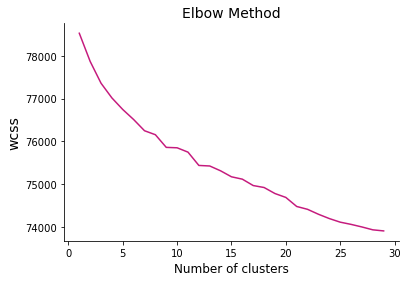

In [15]:
#Use elbow method to find proper K
wcss = []
for i in range(1,30):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,30),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show()

In [18]:
#train Kmeans using true K
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_

Cluster: 0
Titles


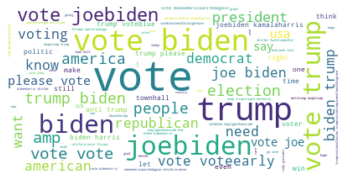

Cluster: 1
Titles


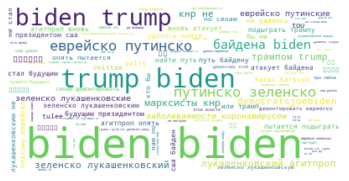

Cluster: 2
Titles


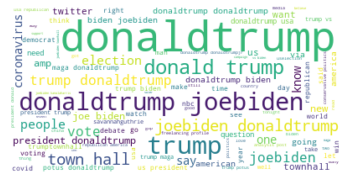

Cluster: 3
Titles


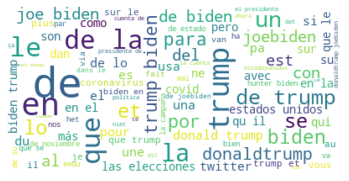

Cluster: 4
Titles


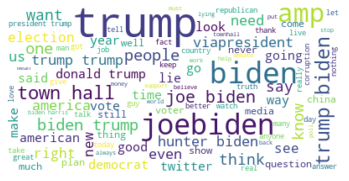

Cluster: 5
Titles


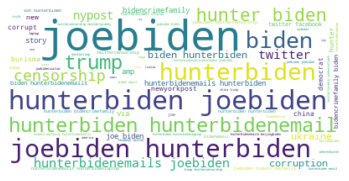

Cluster: 6
Titles


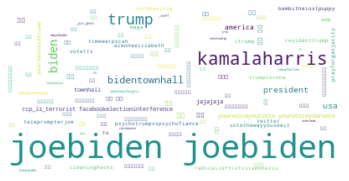

In [19]:
#print word clouds 
from wordcloud import WordCloud
result={'cluster':labels,'wiki':data}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()